# Preparação Dos Dados


In [3]:
import pandas as pd
import os

# Leitura dos dados originais
# mostrar todas as colunas
pd.set_option('display.max_columns', None)
file_path = 'data/TUCURUI_DIARIA_1939_2016.xlsx'
data = pd.read_excel(file_path, header=None, names=['Vazao'])

# Função para calcular derivadas percentuais
def calcular_derivadas(data):
    data['V1'] = data['Vazao'].pct_change() * 100  # Primeira derivada
    data['V2'] = data['V1'].diff() # Segunda derivada
    return data



# Função para criar defasagens
def criar_defasagens(data, colunas, entradas):
    defasagens_list = []

    for col in colunas:
        for i in range(entradas, 0, -1):
            defasagens_list.append(data[col].shift(i).rename(f'Entrada_{col}_{i}'))
        defasagens_list.append(data[col])

    for i in range(1, 12):
        defasagens_list.append(data['Vazao'].shift(-i).rename(f'Saida_{i}'))
    defasagens = pd.concat(defasagens_list, axis=1)
    return defasagens

# **MODELO 1**

In [4]:
# Criar datasets com defasagem apenas na coluna 'Vazao'
data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)

# Pasta onde os arquivos serão salvos

output_folder = 'data/modelo_1'

# Criar a pasta se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos para os arquivos Excel
file_path_15 = os.path.join(output_folder, 'data_15_dias.xlsx')
file_path_30 = os.path.join(output_folder, 'data_30_dias.xlsx')
file_path_45 = os.path.join(output_folder, 'data_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_15.to_excel(file_path_15, index=False)
data_30.to_excel(file_path_30, index=False)
data_45.to_excel(file_path_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


# **MODELO 2**



In [5]:
# Calcular derivadas
data_com_derivadas = calcular_derivadas(data)

# Criar datasets com defasagem nas colunas 'V2', 'V1' e 'Vazao'
data_derivadas_15 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 15)
data_derivadas_30 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 30)
data_derivadas_45 = criar_defasagens(data_com_derivadas, ['V2', 'V1','Vazao'], 45)

# Pasta onde os arquivos serão salvos, dentro de 'data'
output_folder = 'data/modelo_2'

# Criar a pasta 'modelo_2' dentro de 'data' se ela não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Caminhos  para os arquivos Excel
file_path_derivadas_15 = os.path.join(output_folder, 'data_derivadas_15_dias.xlsx')
file_path_derivadas_30 = os.path.join(output_folder, 'data_derivadas_30_dias.xlsx')
file_path_derivadas_45 = os.path.join(output_folder, 'data_derivadas_45_dias.xlsx')

# Salvar os DataFrames em arquivos Excel
data_derivadas_15.to_excel(file_path_derivadas_15, index=False)
data_derivadas_30.to_excel(file_path_derivadas_30, index=False)
data_derivadas_45.to_excel(file_path_derivadas_45, index=False)

print("DataFrames salvos com sucesso!")

DataFrames salvos com sucesso!


In [6]:
data = data[['V2', 'V1', 'Vazao']]
data

,V2,V1,Vazao
0,NaN,NaN,2110
1,NaN,-0.995261,2089
2,-0.871661,-1.866922,2050
3,-0.084298,-1.951220,2010
4,1.005946,-0.945274,1991
...,...,...,...
17284,-1.364289,0.389105,5418
17285,-3.028455,-2.639350,5275
17286,-1.531266,-4.170616,5055
17287,-0.517811,-4.688427,4818


# **MODELO 3**


# **TREINAMENTO**


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Função para preparar os dados (remover NaNs e separar em treino e teste)
def prepare_data(data, features, target, test_size=0.2):
    data = data.dropna()
    X = data[features]
    y = data[target]
    split_idx = int(len(data) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

# **TREINAMENTO - MODELO 1**


# **TREINAMENTO - MODELO 2**


In [30]:
features = data_derivadas_15.filter(regex='^(?!.*Saida).*$').columns.tolist()
target = data_derivadas_15.filter(regex='^Saida').columns.tolist()

X_train, X_test, y_train, y_test = prepare_data(data_derivadas_15, features, target)

# Definição da arquitetura do modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),  # Camada oculta com ativação ReLU
    Dense(32, activation='relu'),  # Segunda camada oculta com ativação ReLU
    Dense(len(target))  # Camada de saída
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 41111004.0000 - val_loss: 3790533.2500
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6385743.5000 - val_loss: 3386345.2500
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5350353.0000 - val_loss: 3074222.2500
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4866292.0000 - val_loss: 2966272.0000
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4738063.5000 - val_loss: 2787919.2500
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4575716.5000 - val_loss: 2882900.7500
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4288050.0000 - val_loss: 2696092.7500
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4353732.5000 - val_loss: 2647393.5000
Epoch 9/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4157890.2500 - val_loss: 2984696.2500
Epoch 10/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4228058.0000 - val_loss: 4006668.2500
Epoch 11/50
432/432 ━━━━━━━━━

# **Avaliação do modelo**


**MAPE (ERRO PERCENTUAL MÉDIO)**

In [35]:
# Avaliação do modelo com Erro Médio Absoluto Percentual (MAPE)
predictions = model.predict(X_test)
mape = tf.keras.losses.MeanAbsolutePercentageError()
mape_value = mape(y_test, predictions).numpy()
print(f'Erro Percentual Médio no conjunto de teste: {mape_value}%')

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
Erro Percentual Médio no conjunto de teste: 12.433731079101562%


**PREVISÃO x REAL**

In [34]:
import pandas as pd

# Criar um DataFrame com as primeiras 15 previsões e valores reais
df_comparacao = pd.DataFrame({
    'Previsão': predictions[:15].flatten(),
    'Reais': y_test.values[:15].flatten()
})

# Exibir a tabela
print(df_comparacao)

        Previsão   Reais
0    2772.447021  2972.0
1    2627.369385  2896.0
2    2490.411133  2885.0
3    2377.333008  2741.0
4    2279.763184  2800.0
..           ...     ...
160  2143.237061  2517.0
161  2105.345947  2476.0
162  2020.250977  2437.0
163  2006.711792  2364.0
164  1988.831665  2363.0

[165 rows x 2 columns]


**GRÁFICO**


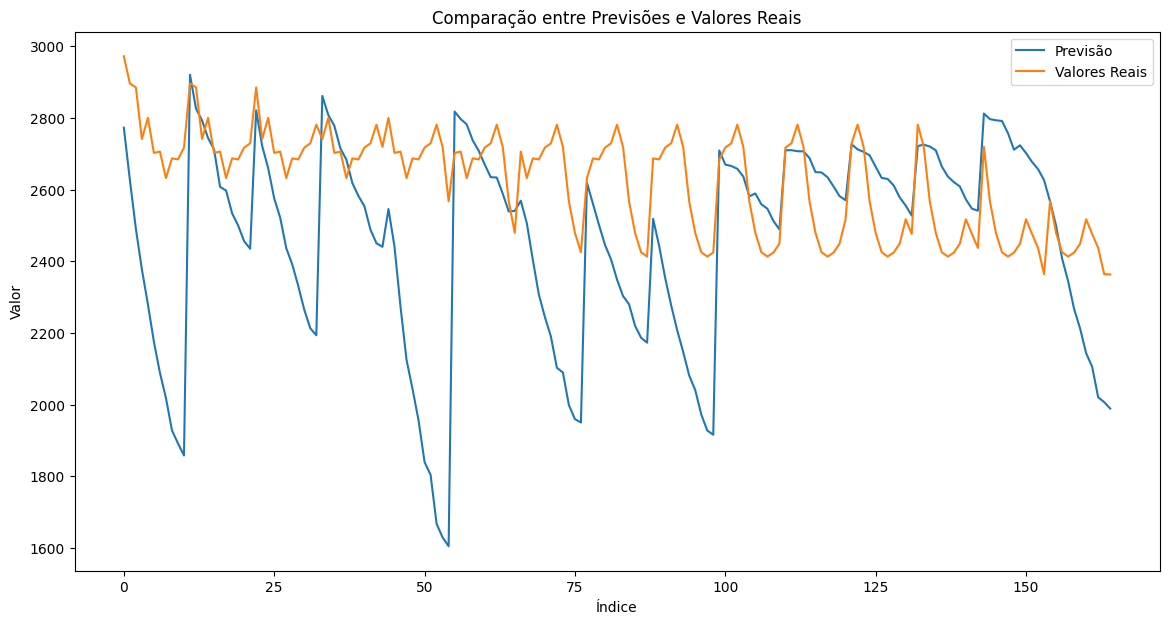

In [33]:
import matplotlib.pyplot as plt

# Plotar previsões e valores reais
plt.figure(figsize=(14, 7))
plt.plot(df_comparacao['Previsão'], label='Previsão')
plt.plot(df_comparacao['Reais'], label='Valores Reais')
plt.legend()
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()